## Последовательный обратный отбор признаков
Последовательный обратный отбор признаков (Sequential backward selection, SBS) - стремится уменьшить размерность исходного пространства признаков с минимальным ухуджешием работоспособности классификатора.


___
P.S. Так же можно посмотреть алгоритмы sequential forward selection, plus-l minus-r selection, bidirectional search и floating search

Работу алгоритма можно разделить на 4 шага:
1. Инициализация, выбор k=d, где d - это размерность полнопризнакового пространства
2. Определить признак $\overline{x}$, который макимизирует критерий $\overline{x}=argmaxJ(X_k-x)$, где $x \in X_k$
3. Удалить признак $\overline{x}$ из набора признаков
4. Закончить если k равняется числу требуемых признаков, в противном случае вернуться к шагу 2

In [1]:
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import numpy as np
from itertools import combinations

In [17]:
class SBS():
    def __init__(self, estimator, k_features, 
                 scoring=accuracy_score,
                 test_size=.25, random_state=1):
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.scoring = scoring
        self.test_size = test_size
        self.random_state = random_state
        
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y,
                             test_size=self.test_size,
                             random_state=self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train,
                                 X_test, y_test,
                                 self.indices_)
        self.scores_ = [score]
        
        while dim > self.k_features:
            scores = []
            subsets = []
            
            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train,
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
                
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        
        return self
    
    def transform(self, X):
        return X[:, self.indices_]
    
    def _calc_score(self, X_train, y_train,
                   X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score
    

Проверим работу SBS на примере

In [18]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import numpy as np
import pandas as pd


df = pd.read_csv('../data/wine/wine.data', header=None)
df.columns = [
    'Label',
    'Alcohol',
    'Malic acid',
    'Ash',
    'Alcalinity of ash',
    'Magnesium',
    'Total phenols',
    'Flavanoids',
    'Nonflavanoid phenols',
    'Proanthocyanins',
    'Color intensity',
    'Hue',
    'OD280/OD315',
    'Proline',
]

X, y = df.iloc[:, 1:].values, df.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

ss = StandardScaler()
X_train_std = ss.fit_transform(X_train)
X_test_std = ss.transform(X_test)

In [21]:
knn = KNeighborsClassifier(n_neighbors=2)
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train);

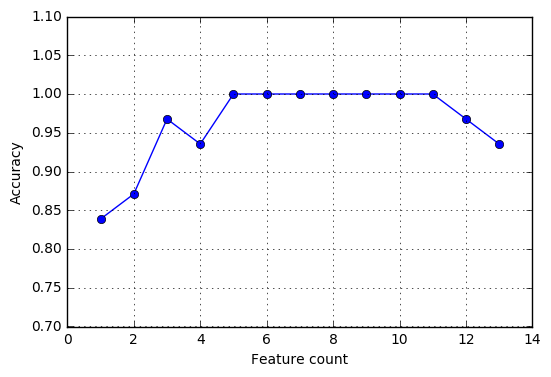

In [22]:
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([.7, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Feature count')
plt.grid()
plt.show()

In [23]:
k5 = list(sbs.subsets_[8])
print(df.columns[1:][k5])

Index(['Alcohol', 'Malic acid', 'Alcalinity of ash', 'Hue', 'Proline'], dtype='object')


In [25]:
knn.fit(X_train_std, y_train)
print('Accuracy on train set: ', knn.score(X_train_std, y_train))
print('Accuracy on test set:', knn.score(X_test_std, y_test))

Accuracy on train set:  0.983870967742
Accuracy on test set: 0.944444444444


In [27]:
knn.fit(X_train_std[:, k5], y_train)
print('Accuracy on train set: ', knn.score(X_train_std[:, k5], y_train))
print('Accuracy on test set:', knn.score(X_test_std[:, k5], y_test))

Accuracy on train set:  0.959677419355
Accuracy on test set: 0.962962962963
